In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import yaml

path_to_experiments = "./"
#get all experiment folders
experiment_folders = [f.path for f in os.scandir(path_to_experiments) if f.is_dir()]   


In [7]:
#for each folder split the name by _ and get parameters
df = pd.DataFrame(columns=["folder", "sample_size", "volume_depth","run_number", "batch_number", "list_of_pixel_score"])
for folder in experiment_folders:
    params = folder.split("_")
    sample_size = params[1]
    volume_depth = params[2]
    run_files = [f.path for f in os.scandir(folder) if f.is_file() and "run" in f.name]
    for run_file in run_files:
        run_number = run_file.split("_")[-1].split(".")[0]
        with open(run_file, 'r') as f:
            run_data = yaml.safe_load(f)
        batch_numbers = list(run_data.keys())
        for batch_number in batch_numbers:
            number = int(batch_number.split("_")[-1])
            #save pixelscore as np array
            pixel_scores = np.array(run_data[batch_number])
            df = pd.concat([df, pd.DataFrame([[folder, sample_size, volume_depth, run_number, number, pixel_scores]], columns=df.columns)], ignore_index=True)    

In [9]:
df.head(),df.tail()

(                     folder sample_size volume_depth run_number batch_number  \
 0  ./condDDPM_16_32_0.6_0.4          16           32          3            0   
 1  ./condDDPM_16_32_0.6_0.4          16           32          3            1   
 2  ./condDDPM_16_32_0.6_0.4          16           32          3           10   
 3  ./condDDPM_16_32_0.6_0.4          16           32          3           11   
 4  ./condDDPM_16_32_0.6_0.4          16           32          3           12   
 
                                  list_of_pixel_score  
 0  [188, 163, 197, 151, 194, 183, 185, 163, 180, ...  
 1  [149, 156, 130, 183, 168, 175, 139, 246, 124, ...  
 2  [114, 200, 235, 62, 187, 219, 164, 160, 208, 1...  
 3  [150, 150, 192, 138, 181, 190, 99, 122, 238, 1...  
 4  [149, 61, 188, 138, 146, 107, 216, 170, 239, 2...  ,
                        folder sample_size volume_depth run_number  \
 2290  ./condDDPM_16_8_0.6_0.4          16            8          0   
 2291  ./condDDPM_16_8_0.6_0.4     

In [10]:
#normalize pixel scores by using samples_size**2 as the maximum possible score, read the sample_size from the folder name
df["normalized_pixel_score"] = df["list_of_pixel_score"] / (df["sample_size"].astype(int) ** 2)

In [12]:
#create mean, std, min, max columns for normalized_pixel_score
df["mean_normalized_pixel_score"] = df["normalized_pixel_score"].apply(np.mean)
df["std_normalized_pixel_score"] = df["normalized_pixel_score"].apply(np.std)
df["min_normalized_pixel_score"] = df["normalized_pixel_score"].apply(np.min)
df["max_normalized_pixel_score"] = df["normalized_pixel_score"].apply(np.max)

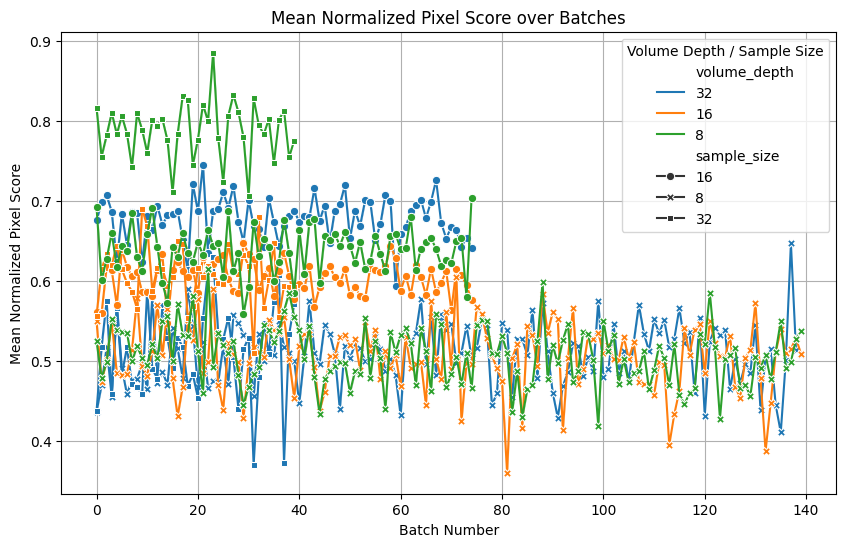

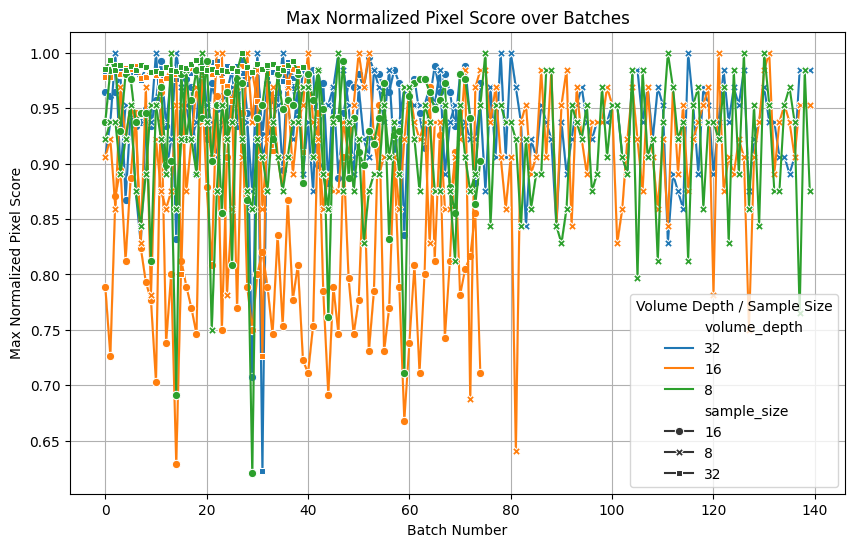

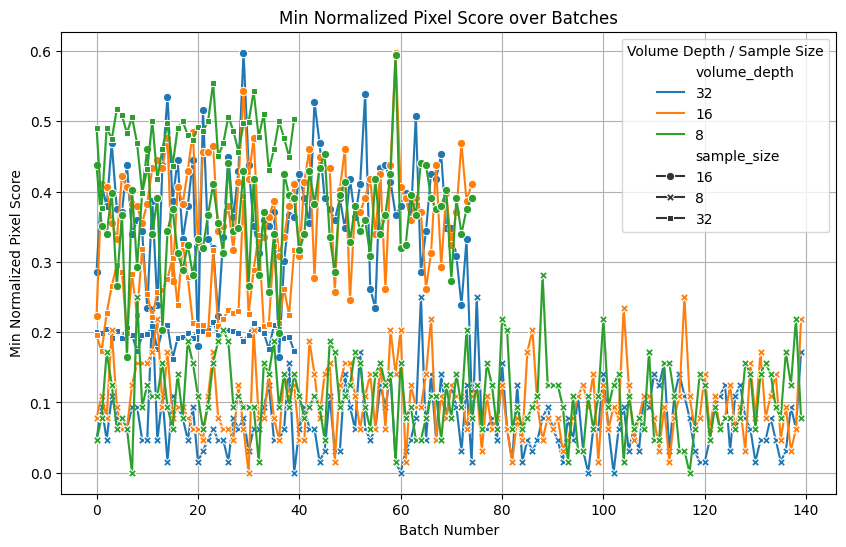

In [16]:

#plot with seaborn lineplot with hue as volume_depth and style as sample_size
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="batch_number", y="mean_normalized_pixel_score", hue="volume_depth", style="sample_size", markers=True, dashes=False)
plt.title("Mean Normalized Pixel Score over Batches")
plt.xlabel("Batch Number")
plt.ylabel("Mean Normalized Pixel Score")
plt.legend(title="Volume Depth / Sample Size")
plt.grid()
plt.show()

#same for max
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="batch_number", y="max_normalized_pixel_score", hue="volume_depth", style="sample_size", markers=True, dashes=False)
plt.title("Max Normalized Pixel Score over Batches")
plt.xlabel("Batch Number")
plt.ylabel("Max Normalized Pixel Score")
plt.legend(title="Volume Depth / Sample Size")
plt.grid()
plt.show()

#same for min
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="batch_number", y="min_normalized_pixel_score", hue="volume_depth", style="sample_size", markers=True, dashes=False)
plt.title("Min Normalized Pixel Score over Batches")
plt.xlabel("Batch Number")
plt.ylabel("Min Normalized Pixel Score")
plt.legend(title="Volume Depth / Sample Size")
plt.grid()
plt.show()